# A PGM for Solving Sudoku Problems
This example shows how PGM's can also be used to solve deterministic logic problems.
Here we use veroku to develop an class that can automatically build cluster graphs for
soduko problems and then use message passing inference to solve these problems.

In [1]:
import sys
sys.path.append('../../')

In [2]:
from veroku.factors.categorical import Categorical
from veroku.factors.sparse_categorical import SparseCategorical
from veroku.cluster_graph import ClusterGraph
import numpy as np
import pandas as pd
import itertools

### Sudoku Board Class

In [3]:
def has_int_square_root(value):
    root = value**0.5
    root = float(round(root))
    return root**2.0  == value


class SudokuBoard:
 
    def __init__(self, starting_board_state):
        """
        Construct a Sudoku board instance.
        Note: cell indices and cell variable names are the same.
        """
        assert starting_board_state.shape[0] == starting_board_state.shape[1], "Error: board must be square"
        assert has_int_square_root(starting_board_state.shape[0]), 'board dim must have integer square root.'
        self.starting_board_state = starting_board_state.copy()
        self.board_dim = starting_board_state.shape[0]
        self.board_array = np.array(range(starting_board_state.shape[0]**2)).reshape([self.board_dim, self.board_dim])
        assert starting_board_state.shape == self.board_array.shape, 'Error: Inconsistent starting board and block dim'
        self.solution = None
        self.clustergraph = None

        # get observations dictionary
        self.evidence_dict  = dict()
        for i in range(self.board_array.shape[0]):
            for j in range(self.board_array.shape[1]):
                if starting_board_state[i,j] != 0:
                    var_name = str(self.board_array[i,j])
                    self.evidence_dict[var_name] = starting_board_state[i,j]
            
        self.block_dim = int(self.board_dim**0.5)
        block_index = 0
        self.block_cell_lists = dict() # a dictionary mapping the block id to the cells (their cell ids) contained in it
        for i_ in np.linspace(0, self.board_array.shape[0], self.block_dim, endpoint=False):
            for j_ in np.linspace(0, self.board_array.shape[1], self.block_dim, endpoint=False):
                i, j = int(i_), int(j_)
                cell_array = self.board_array[i:i+self.block_dim, j:j+self.block_dim]
                self.block_cell_lists[block_index] = list(cell_array.ravel())
                block_index += 1
                
        
        self.row_cell_lists = dict() # a dictionary mapping the row id to the cells (their cell ids) contained in it
        for i in range(self.board_array.shape[0]):
            self.row_cell_lists[i] = list(self.board_array[i,:])

        self.col_cell_lists = dict() # a dictionary mapping the row id to the cells (their cell ids) contained in it
        for i in range(self.board_array.shape[1]):
            self.col_cell_lists[i] = list(self.board_array[:,i])
    
    @staticmethod
    def get_formatable_cell_strings(num_cells):
        cell_fstrings = ['cell_({})'.format(i).replace('(','{').replace(')','}') for i in range(num_cells)]
        return cell_fstrings
    
    def get_cells_factor(self, cell_var_names):
        assert len(cell_var_names) == self.block_dim**2, f'Error: incorrect number of cells: {len(cell_var_names)} != {self.block_dim**2}'
        num_cell_possible_values = self.block_dim**2
        permutations = list(itertools.permutations(range(1,num_cell_possible_values+1)))
        probs_table = {assign:1.0 for assign in permutations}

        cell_value_cardinalities = [num_cell_possible_values]*num_cell_possible_values
        factor = SparseCategorical(probs_table=probs_table,
                                   var_names=cell_var_names,
                                   cardinalities=cell_value_cardinalities)
        return factor
    
    def get_all_factors(self):
        # get block factors
        factors = []
        #print('get block factors')
        for block_cell_vars in self.block_cell_lists.values():
            factor = self.get_cells_factor([str(v) for v in block_cell_vars])
            factors.append(factor)
        # get row factors
        #print('get row factors')
        for row_cell_vars in self.row_cell_lists.values():
            factor = self.get_cells_factor([str(v) for v in row_cell_vars])
            factors.append(factor)
        # get column factors
        #print('get column factors')
        for col_cell_vars in self.col_cell_lists.values():
            factor = self.get_cells_factor([str(v) for v in col_cell_vars])
            factors.append(factor)
        return factors
    
    def build_cluster_graph(self):
        factors = self.get_all_factors()
        print('num factors: ', len(factors))
        self.clustergraph = ClusterGraph(factors=factors, evidence=self.evidence_dict)
    
    def compute_solution(self):
        if self.clustergraph is None:
            self.build_cluster_graph()
        self.clustergraph.process_graph(sync=False)
        self.solution = np.zeros(self.board_array.shape)
        for i in range(self.board_array.shape[0]):
            for j in range(self.board_array.shape[1]):
                final_var_value = self.starting_board_state[i,j]
                if final_var_value == 0: # var was not given
                    cell_var = self.board_array[i,j]
                    cell_posterior_marginal = self.clustergraph.get_marginal([str(cell_var)])
                    final_var_value = cell_posterior_marginal.argmax()[0]
                self.solution[i,j] = final_var_value
        return self.solution.copy()

### Solution Evaluation

In [4]:
from IPython.display import display, HTML
def check_solution(inferred_solution, correct_solution):
    equals_mat = inferred_solution == correct_solution
    solution_df = pd.DataFrame(correct_solution,index=range(correct_solution.shape[0])).applymap(lambda x: int(x))
    if all(equals_mat.ravel()):
        print('\n      Solution is correct!\n')
        style_dict = {'background-color': 'green',
                       'color': 'lawngreen',
                       'border-color': 'white'}
    else:
        print('Solution is incorrect.')
        style_dict = {'background-color': 'red',
                       'color': 'darkred',
                       'border-color': 'white'}
    solution_df = solution_df.rename(columns={i:str(i)+' .' for i in range(9)})

    display(solution_df.style.set_properties(**style_dict))

### Data Access

In [5]:
import requests

def get_sudoku_problem_array_from_url(url):
    sudoku_problem_string = str(requests.get(url).content.decode("utf-8"))
    row_vector_strings = sudoku_problem_string.split('\n')
    array = np.vstack([np.fromstring(s, sep=' ') for s in row_vector_strings if len(s) != 0])
    return array

def get_sudoku_solution_array_from_url(url):
    sudoku_problem_string = str(requests.get(url).content.decode("utf-8"))
    sudoku_problem_string = sudoku_problem_string.replace('-','')
    sudoku_problem_string = sudoku_problem_string.replace('|','')
    sudoku_problem_string = sudoku_problem_string.replace('0','')
    sudoku_problem_string = sudoku_problem_string.replace('45','')
    sudoku_problem_string = sudoku_problem_string.replace('= ,','')
    sudoku_problem_string = sudoku_problem_string.replace('  ',' ')
    row_vector_strings = sudoku_problem_string.split('\n')
    array = np.vstack([np.fromstring(s, sep=' ') for s in row_vector_strings if len(s) == 18])
    return array


In [6]:
problem_files = ['s01a.txt','s01b.txt','s01c.txt','s02a.txt','s02b.txt','s02c.txt','s03a.txt','s03b.txt','s03c.txt']
solution_files = [f.replace('.txt', '_s.txt')for f in problem_files]


In [7]:
problem_file_index = 0
url = 'http://lipas.uwasa.fi/~timan/sudoku/'
problem_url = f'{url}{problem_files[problem_file_index]}' 
solution_url = f'{url}{solution_files[problem_file_index]}' 

board_start_state = get_sudoku_problem_array_from_url(problem_url)
solution_array_st = get_sudoku_solution_array_from_url(solution_url)

In [8]:
print('Problem:')
pd.DataFrame(board_start_state,index=range(board_start_state.shape[0])).applymap(lambda x: '' if x==0.0 else x)

Problem:


,0,1,2,3,4,5,6,7,8
0,,4,,,,,1,7,9
1,,,2,,,8,,5,4
2,,,6,,,5,,,8
3,,8,,,7,,9,1,
4,,5,,,9,,,3,
5,,1,9,,6,,,4,
6,3,,,4,,,7,,
7,5,7,,1,,,2,,
8,9,2,8,,,,,6,


In [9]:
print('\nSolution:')
pd.DataFrame(solution_array_st,index=range(solution_array_st.shape[0])).applymap(lambda x: int(x))


Solution:


,0,1,2,3,4,5,6,7,8
0,8,4,5,6,3,2,1,7,9
1,7,3,2,9,1,8,6,5,4
2,1,9,6,7,4,5,3,2,8
3,6,8,3,5,7,4,9,1,2
4,4,5,7,2,9,1,8,3,6
5,2,1,9,8,6,3,5,4,7
6,3,6,1,4,2,9,7,8,5
7,5,7,4,1,8,6,2,9,3
8,9,2,8,3,5,7,4,6,1


### Soduko PGM Inference and Results

In [10]:
sudoku_board = SudokuBoard(board_start_state)

In [11]:
sudoku_board.build_cluster_graph()

num factors:  27


../../veroku/cluster_graph.py:89: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  data = np.array([list(subset_dict.keys()), list(subset_dict.values())]).T


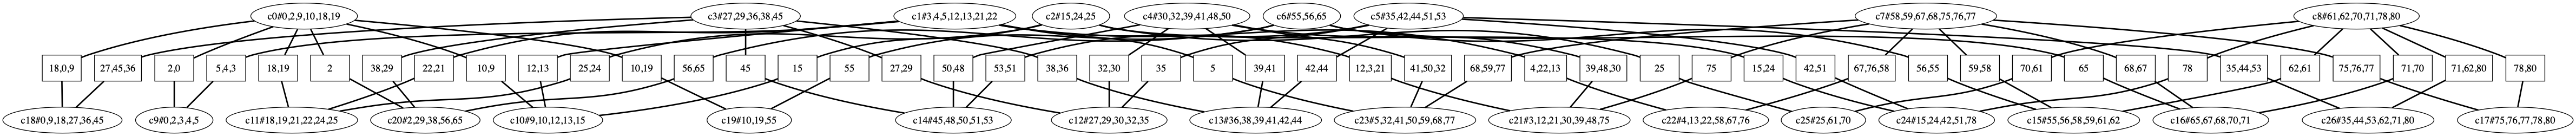

In [12]:
sudoku_board.clustergraph.show()

In [13]:
solution = sudoku_board.compute_solution()

Info: Starting iterative message passing.*


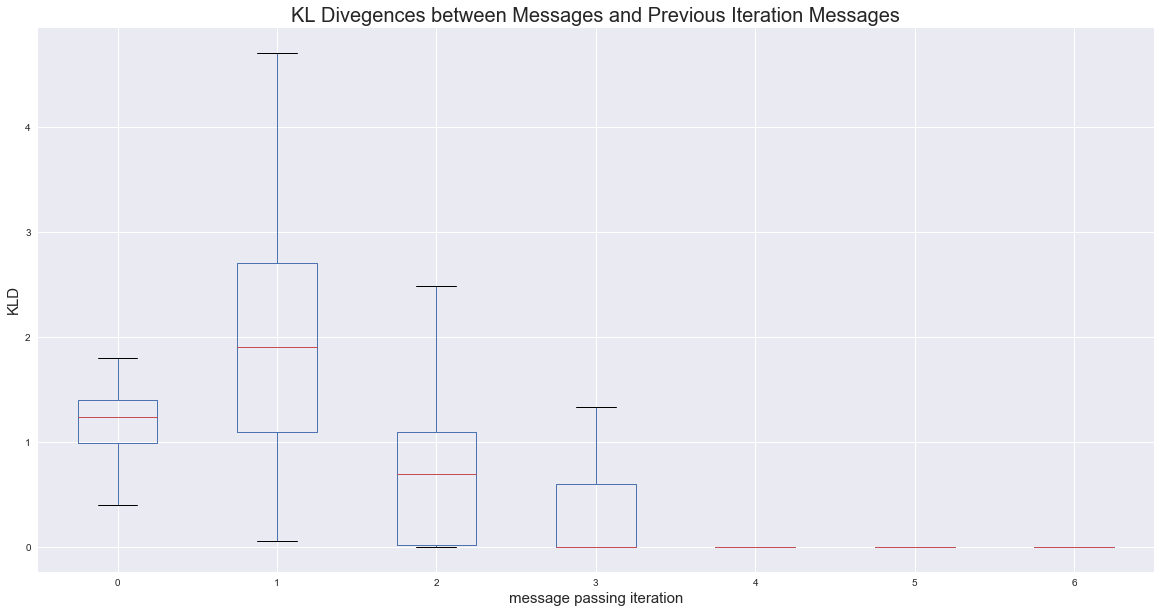

In [14]:
message_kld_df = sudoku_board.clustergraph.plot_message_convergence()

In [17]:
assert(np.array_equal(solution, solution_array_st))
check_solution(solution, solution_array_st)


      Solution is correct!



,0 .,1 .,2 .,3 .,4 .,5 .,6 .,7 .,8 .
0,8,4,5,6,3,2,1,7,9
1,7,3,2,9,1,8,6,5,4
2,1,9,6,7,4,5,3,2,8
3,6,8,3,5,7,4,9,1,2
4,4,5,7,2,9,1,8,3,6
5,2,1,9,8,6,3,5,4,7
6,3,6,1,4,2,9,7,8,5
7,5,7,4,1,8,6,2,9,3
8,9,2,8,3,5,7,4,6,1
